# Big data analysis using machine learning and probabilistic models 
# part B - 2D distributions (pairs of cells / genes)

### General Instructions 
Follow the instructions below to analyze the data matrix “mm_gastru_small.h5ad”. You are free to use any package or software (in Python or R). As we are practicing here data analysis, which is always done under uncertainty, you will find that in many cases you need to make hard decisions on parameters/algorithms/visualization. This is OK. There is no single “correct” solution – a perfect project will be one that conveys understanding of the underlying data using the methodologies we studied.<br />
<br />
Describe your work in:<br />
A Jupyter notebook with explanations in markdown and comments.<br />
Alternatively, provide A written report (pdf) with concise description of what you find, including figures (strict limit on length is 6 pages – keep figures small..). As well as your “source” code (no need to have it documented, but put sections in it per figure you are generating.<br />
Please work alone. You are however free to discuss with fellow students regarding tools and analysis strategies. 


### ExerciseB: In this stage you'll explorer the notion of correlation between features and how to identify groups of correlated features

In [1]:
import anndata as ad
import scanpy as sc
# import metacells as mc
import pandas as pd
import numpy as np
import sklearn as skl
from scipy.stats import spearmanr, pearsonr
from scipy.special import betainc
from statsmodels.stats.multitest import multipletests
import matplotlib.pylab as plt
import seaborn as sns
import pickle
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import rankdata

In [2]:
if os.getcwd() != "/home/labs/antebilab/guyilan/master/aihub/Tutorials/AIhub/ex-scrna":
    os.chdir("/home/labs/antebilab/guyilan/master/aihub/Tutorials/AIhub/ex-scrna")

# 2D distributions (pairs of cells / genes)

[We continue with the cleaned and downsampled matrices from the previous section]

In [3]:
#load cleaned and downsampled data from adata_filt_ds_df.pkl:
data = pickle.load(open("adata_filt_ds_df.pkl", "rb"))
data.head()

,AB347151,AB347871,AB347889,AK008665,AK155692,AK186242,AK186650,AK191723,AK195420,AK199495,...,Ywhae,Ywhag,Ywhah,Ywhaz,Zbed5,Zc3h15,Zfos1,Zfp36l2,Zfp706,Zranb2
181209_P01.181209_P01001,1.0,0.0,0.0,0.0,1.0,11.0,1.0,2.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
181209_P01.181209_P01002,0.0,0.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
181209_P01.181209_P01003,2.0,0.0,0.0,4.0,0.0,10.0,0.0,0.0,1.0,4.0,...,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
181209_P01.181209_P01004,1.0,0.0,0.0,6.0,1.0,4.0,3.0,3.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
181209_P01.181209_P01005,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,3.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
df_norm = pickle.load(open("df_norm_filt.pkl", "rb"))
df_norm.head()

,AB347151,AB347871,AB347889,AK008665,AK033180,AK155692,AK186242,AK186650,AK191723,AK195420,...,Ythdf1,Ywhab,Ywhae,Ywhag,Ywhah,Ywhaz,Zbed5,Zc3h15,Zfos1,Zfp706
181209_P01.181209_P01001,0.000804,0.0,0.000402,0.000804,0.000804,0.000402,0.011661,0.000804,0.001608,0.000804,...,0.000402,0.001206,0.004021,0.000804,0.000000,0.000402,0.0,0.000402,0.000000,0.000000
181209_P01.181209_P01002,0.000179,0.0,0.000893,0.001071,0.000893,0.000714,0.011782,0.000893,0.001964,0.000357,...,0.000000,0.000357,0.003035,0.000714,0.000714,0.000000,0.0,0.000000,0.000179,0.000357
181209_P01.181209_P01003,0.001051,0.0,0.001051,0.002627,0.001576,0.001051,0.008408,0.000525,0.001051,0.000525,...,0.000000,0.001051,0.002102,0.001051,0.000000,0.001051,0.0,0.000000,0.000000,0.001576
181209_P01.181209_P01004,0.001201,0.0,0.000801,0.004003,0.000000,0.001601,0.007206,0.001601,0.002002,0.000801,...,0.000801,0.001601,0.001601,0.000400,0.000000,0.000000,0.0,0.000400,0.000000,0.000801
181209_P01.181209_P01005,0.000337,0.0,0.001347,0.000337,0.000673,0.001684,0.009764,0.000000,0.001010,0.002020,...,0.000000,0.000673,0.002020,0.000337,0.001010,0.000673,0.0,0.000000,0.000000,0.001347


## Tasks

1.	Plot scatters of all the genes for a single pair of cells
    Run through several such scatters, for example the cells "190307_P10.190307_P10350" and "190313_P12.190313_P12102”


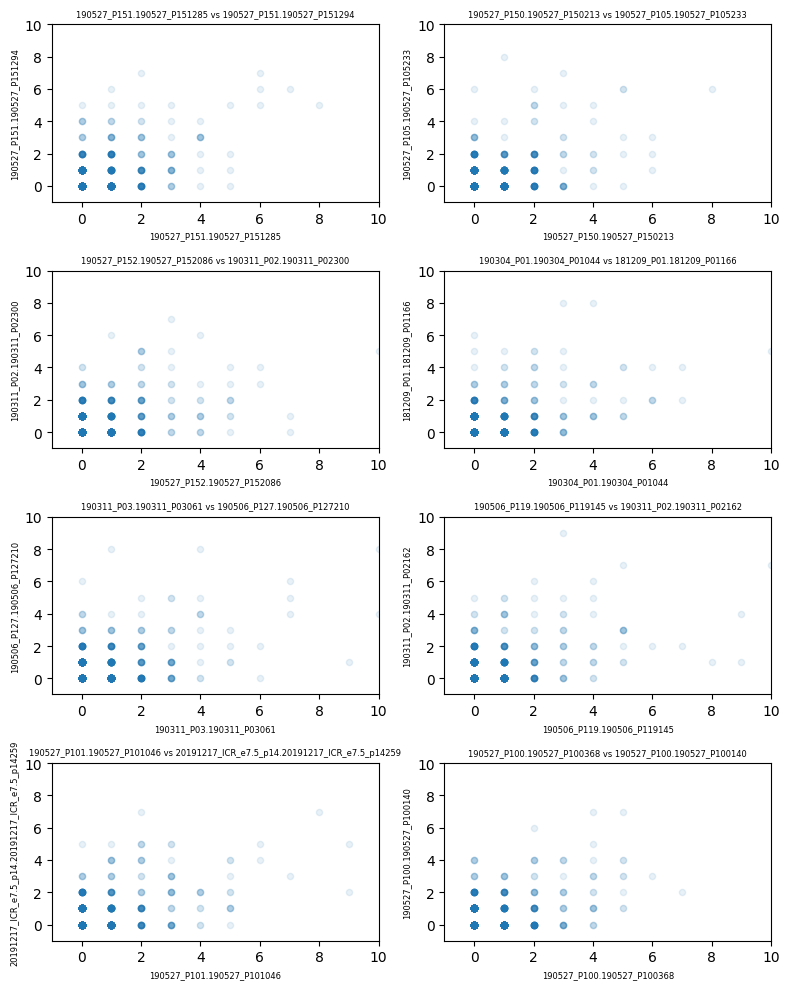

In [5]:
fig, ax = plt.subplots(4, 2, figsize=(8, 10))

# Sample random pair of cells from the data:
for i in range(8):
    cell1 = np.random.choice(data.index)
    cell2 = np.random.choice(data.index)
    
    # Scatter plot
    ax[i//2, i%2].scatter(data.loc[cell1], data.loc[cell2], s=20, alpha=0.1)
    ax[i//2, i%2].set_xlabel(cell1, fontsize=6)
    ax[i//2, i%2].set_ylabel(cell2, fontsize=6)
    ax[i//2, i%2].set_title(f"{cell1} vs {cell2}", fontsize=6)
    ax[i//2, i%2].set_ylim(-1, 10)
    ax[i//2, i%2].set_xlim(-1, 10)

plt.tight_layout()
plt.show()

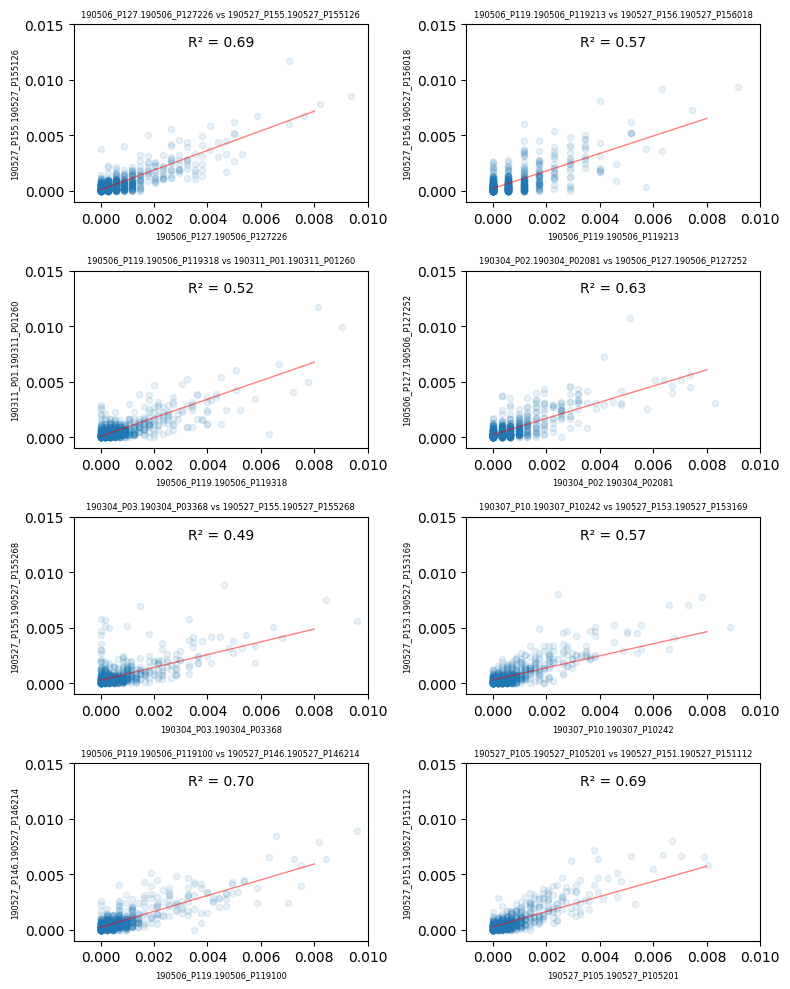

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(8, 10))

for i in range(8):
    cell1 = np.random.choice(df_norm.index)
    cell2 = np.random.choice(df_norm.index)
    
    # Scatter plot
    ax[i//2, i%2].scatter(df_norm.loc[cell1], df_norm.loc[cell2], s=20, alpha=0.1)
    
    # Linear regression
    X = df_norm.loc[cell1].values.reshape(-1, 1)
    y = df_norm.loc[cell2].values
    reg = LinearRegression().fit(X, y)
    x_min, x_max = 0, 0.008
    x_range = np.linspace(x_min, x_max, df_norm.shape[1]).reshape(-1, 1)
    y_range_pred = reg.predict(x_range)
    
    ax[i//2, i%2].plot(x_range, y_range_pred, color='red', linewidth=1, alpha=0.5)
    
    r2 = r2_score(y, reg.predict(X))
    #add r2 as text on the plot:
    ax[i//2, i%2].text(0.5, 0.9, f"R² = {r2:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i//2, i%2].transAxes)
    
    ax[i//2, i%2].set_xlabel(cell1, fontsize=6)
    ax[i//2, i%2].set_ylabel(cell2, fontsize=6)
    ax[i//2, i%2].set_title(f"{cell1} vs {cell2}", fontsize=6)
    ax[i//2, i%2].set_ylim(-0.001, 0.015)
    ax[i//2, i%2].set_xlim(-0.001, 0.01)

plt.tight_layout()
plt.show()

2.  Plot all the cells for a single pair of genes. 
    Run through several such scatters, for example the genes “Pou5f1” and “Dnm53b” 

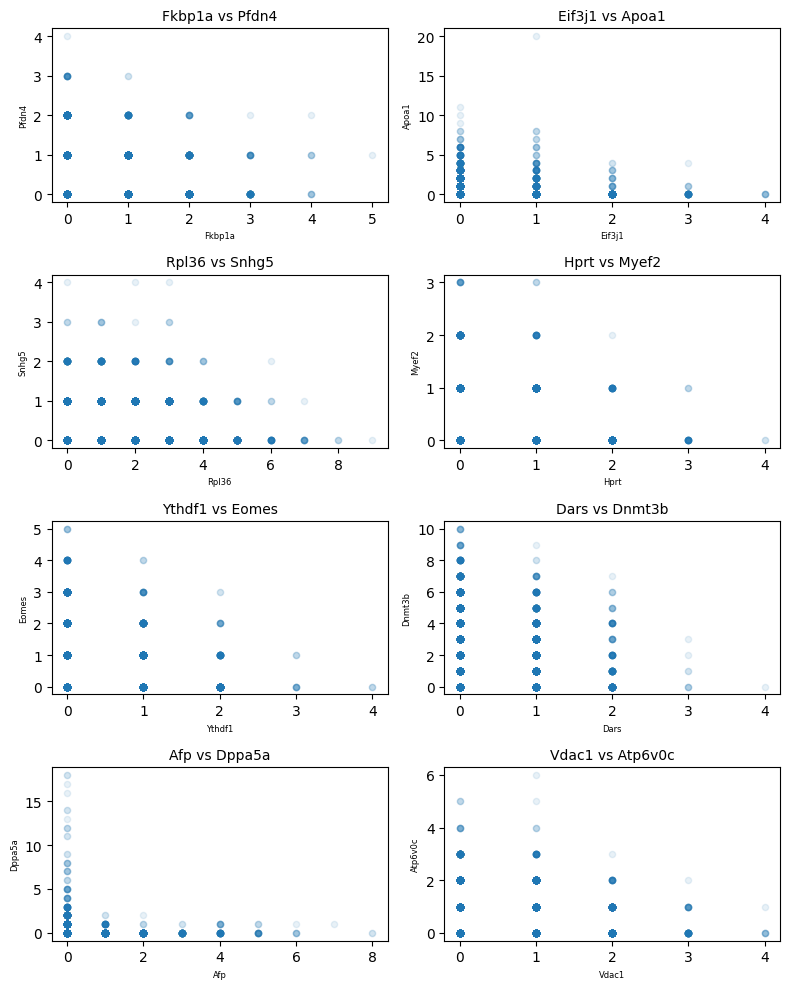

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(8, 10))

for i in range(8):
    gene1 = np.random.choice(data.columns)
    gene2 = np.random.choice(data.columns)
    
    # Scatter plot
    ax[i//2, i%2].scatter(data[gene1], data[gene2], s=20, alpha=0.1)
    ax[i//2, i%2].set_xlabel(gene1, fontsize=6)
    ax[i//2, i%2].set_ylabel(gene2, fontsize=6)
    ax[i//2, i%2].set_title(f"{gene1} vs {gene2}", fontsize=10)
    # ax[i//2, i%2].set_ylim(-0.0005, 0.008)
    # ax[i//2, i%2].set_xlim(-0.0001, 0.005)

plt.tight_layout()
plt.show()

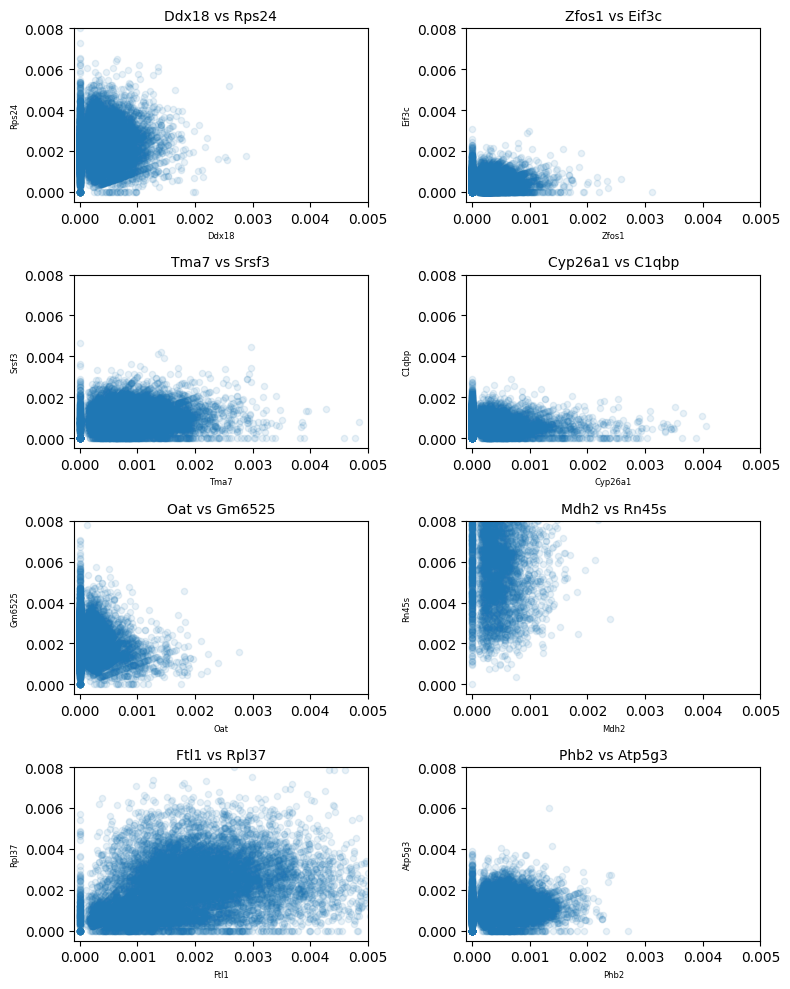

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(8, 10))

for i in range(8):
    gene1 = np.random.choice(df_norm.columns)
    gene2 = np.random.choice(df_norm.columns)
    
    # Scatter plot
    ax[i//2, i%2].scatter(df_norm[gene1], df_norm[gene2], s=20, alpha=0.1)
    ax[i//2, i%2].set_xlabel(gene1, fontsize=6)
    ax[i//2, i%2].set_ylabel(gene2, fontsize=6)
    ax[i//2, i%2].set_title(f"{gene1} vs {gene2}", fontsize=10)
    ax[i//2, i%2].set_ylim(-0.0005, 0.008)
    ax[i//2, i%2].set_xlim(-0.0001, 0.005)

plt.tight_layout()
plt.show()

3.  Sample and calculate correlations between cells / genes 
    for example “Pou5f1” and “Dnmt3b” 

In [9]:
#sample 1000 random pairs of genes and calculate the correlation between them:
correlations = []
for i in range(1000):
    gene1 = np.random.choice(df_norm.columns)
    gene2 = np.random.choice(df_norm.columns)
    if gene1 == gene2:
        continue
    corr = df_norm[gene1].corr(df_norm[gene2])
    correlations.append(corr)

4.  Plot the distributions of these correlations. 
    How do the correlations of the raw data and down-sampled data compare?

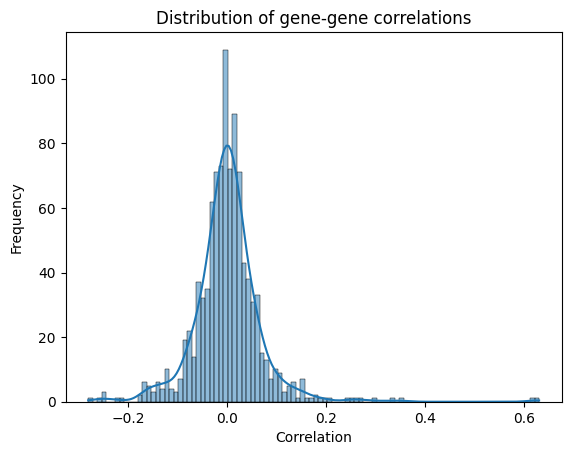

In [10]:
sns.histplot(correlations, bins=100, kde=True)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Distribution of gene-gene correlations")
plt.show()

5.  Compute a cell-to-cell correlation matrix 
    (for efficiency, use “numpy.corrcoef”) 

In [11]:
corr_mat = np.corrcoef(df_norm)

corr_mat.shape

(12603, 12603)

In [12]:
data

,AB347151,AB347871,AB347889,AK008665,AK155692,AK186242,AK186650,AK191723,AK195420,AK199495,...,Ywhae,Ywhag,Ywhah,Ywhaz,Zbed5,Zc3h15,Zfos1,Zfp36l2,Zfp706,Zranb2
181209_P01.181209_P01001,1.0,0.0,0.0,0.0,1.0,11.0,1.0,2.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
181209_P01.181209_P01002,0.0,0.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
181209_P01.181209_P01003,2.0,0.0,0.0,4.0,0.0,10.0,0.0,0.0,1.0,4.0,...,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
181209_P01.181209_P01004,1.0,0.0,0.0,6.0,1.0,4.0,3.0,3.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
181209_P01.181209_P01005,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,3.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14376,0.0,1.0,1.0,1.0,3.0,0.0,0.0,3.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14377,0.0,1.0,0.0,4.0,6.0,0.0,0.0,3.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14378,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14379,1.0,0.0,0.0,3.0,2.0,0.0,0.0,5.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
adata = ad.read_h5ad("mm_gastru_small.h5ad")
df_adata = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)


df_adata_filt = df_adata.loc[data.index, data.columns]

df_adata_filt

,AB347151,AB347871,AB347889,AK008665,AK155692,AK186242,AK186650,AK191723,AK195420,AK199495,...,Ywhae,Ywhag,Ywhah,Ywhaz,Zbed5,Zc3h15,Zfos1,Zfp36l2,Zfp706,Zranb2
181209_P01.181209_P01001,2.0,0.0,1.0,2.0,1.0,29.0,2.0,4.0,2.0,3.0,...,10.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
181209_P01.181209_P01002,1.0,0.0,5.0,6.0,4.0,66.0,5.0,11.0,2.0,11.0,...,17.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0
181209_P01.181209_P01003,2.0,0.0,2.0,5.0,2.0,16.0,1.0,2.0,1.0,5.0,...,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0
181209_P01.181209_P01004,3.0,0.0,2.0,10.0,4.0,18.0,4.0,5.0,2.0,4.0,...,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
181209_P01.181209_P01005,1.0,0.0,4.0,1.0,5.0,29.0,0.0,3.0,6.0,5.0,...,6.0,1.0,3.0,2.0,0.0,0.0,0.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14376,0.0,1.0,2.0,6.0,6.0,2.0,0.0,4.0,1.0,3.0,...,2.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14377,2.0,2.0,1.0,8.0,15.0,6.0,0.0,12.0,1.0,8.0,...,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14378,2.0,1.0,4.0,10.0,8.0,4.0,0.0,21.0,1.0,12.0,...,15.0,1.0,5.0,3.0,1.0,2.0,0.0,3.0,3.0,2.0
20191217_ICR_e7.5_p14.20191217_ICR_e7.5_p14379,5.0,0.0,5.0,17.0,19.0,2.0,0.0,28.0,0.0,5.0,...,4.0,3.0,3.0,1.0,3.0,3.0,0.0,0.0,1.0,0.0


6. Find the top correlated gene for each gene : using pearson on <b>un</b>-normalized mat, pearson, pearson(log), spearman 

    show scatter plots
    compare to feature mean
         show cor needs depth
    repeat on the normalized mat - Is there a difference?
    Repeat on the downsampled mat - Is there a difference?

In [14]:
adata = ad.read_h5ad("mm_gastru_small.h5ad")
df_adata = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)


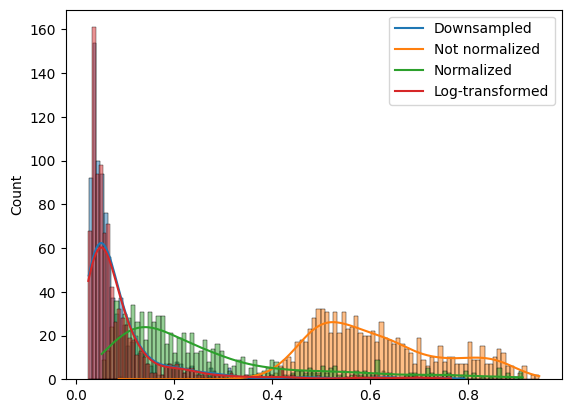

In [15]:
def top_correlated(df):
    corr_mat = np.corrcoef(df)
    np.fill_diagonal(corr_mat, 0)
    return np.max(corr_mat, axis=0)

def top_correlated_spearman(df):
    spearman, _ = spearmanr(df)
    np.fill_diagonal(spearman, 0)
    return np.max(spearman, axis=0)

top_correlated_genes_ds = top_correlated(data.T)
top_correlated_genes_not_norm = top_correlated(df_adata_filt.T)
top_correlated_genes_norm = top_correlated(df_norm.T)
top_correlated_genes_ds_log = top_correlated(np.log1p(data).T)

#hist plto:
sns.histplot(top_correlated_genes_ds, bins=100, kde=True, alpha = 0.5)
sns.histplot(top_correlated_genes_not_norm, bins=100, kde=True, alpha = 0.5)
sns.histplot(top_correlated_genes_norm, bins=100, kde=True, alpha = 0.5)
sns.histplot(top_correlated_genes_ds_log, bins=100, kde=True, alpha = 0.5)

plt.legend(["Downsampled", "Not normalized", "Normalized", "Log-transformed"])

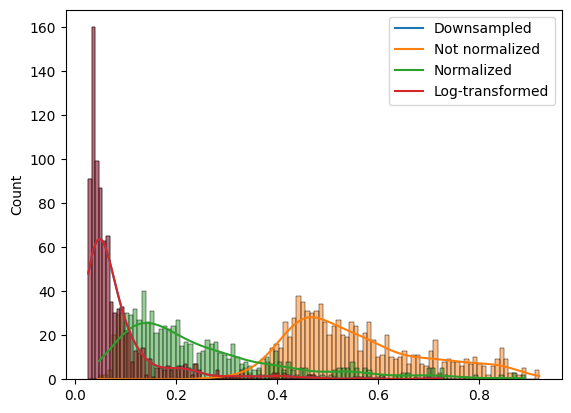

In [16]:
top_correlated_spearman_genes_ds = top_correlated_spearman(data)
top_correlated_spearman_genes_not_norm = top_correlated_spearman(df_adata_filt)
top_correlated_spearman_genes_norm = top_correlated_spearman(df_norm)
top_correlated_spearman_genes_ds_log = top_correlated_spearman(np.log1p(data))

#hist plto:
sns.histplot(top_correlated_spearman_genes_ds, bins=100, kde=True, alpha = 0.5)
sns.histplot(top_correlated_spearman_genes_not_norm, bins=100, kde=True, alpha = 0.5)
sns.histplot(top_correlated_spearman_genes_norm, bins=100, kde=True, alpha = 0.5)
sns.histplot(top_correlated_spearman_genes_ds_log, bins=100, kde=True, alpha = 0.5)

plt.legend(["Downsampled", "Not normalized", "Normalized", "Log-transformed"])

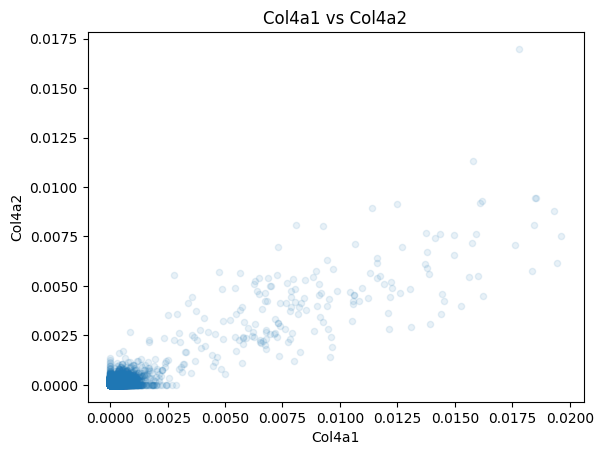

0.9112352529200588


In [17]:
corrmat = np.corrcoef(df_norm.T)
np.fill_diagonal(corrmat, 0)
max_id = np.argmax(corrmat)
max_idx_2d = np.unravel_index(max_id, corrmat.shape)
x, y = max_idx_2d


gene1, gene2 = df_norm.columns[x], df_norm.columns[y] 
plt.scatter(df_norm[gene1], df_norm[gene2], s=20, alpha=0.1)
plt.xlabel(gene1)
plt.ylabel(gene2)
plt.title(f"{gene1} vs {gene2}")
plt.show()

print(df_norm[gene1].corr(df_norm[gene2]))

7. Plot Heat map of correlations on high variance genes (try to use seaborn clusermap)

<Axes: >

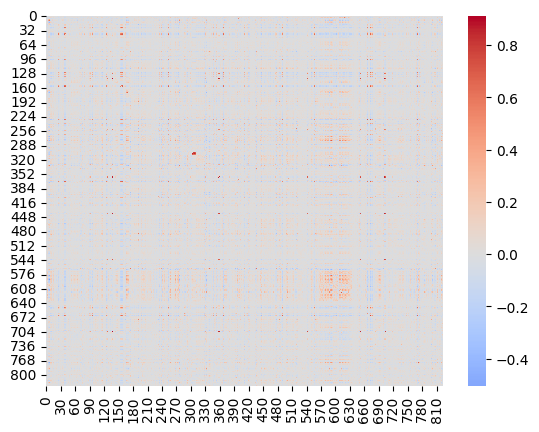

In [18]:
sns.heatmap(corrmat, cmap='coolwarm', center=0)

<Axes: >

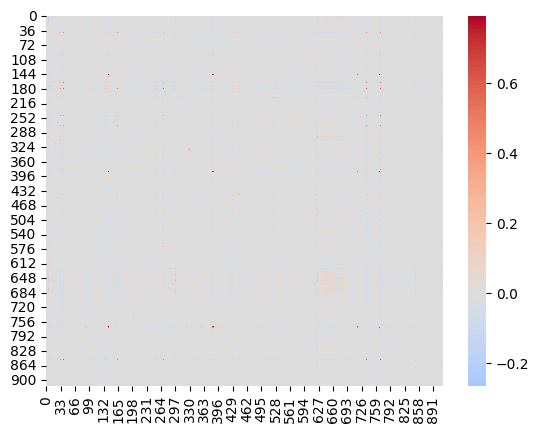

In [19]:
corrmat_data = np.corrcoef(data.T)
np.fill_diagonal(corrmat_data, 0)
sns.heatmap(corrmat_data, cmap='coolwarm', center=0)


8.  Decide on a reasonable statistical test for comparing cells and visualize the distribution of derived statistics
    e.g. if you are doing linear correlation, show the distribution of the R coefficients (Pearson coefficient). 
    Discuss the statistical significance of the test for correlation between two cells, including the multiple-testing effect.

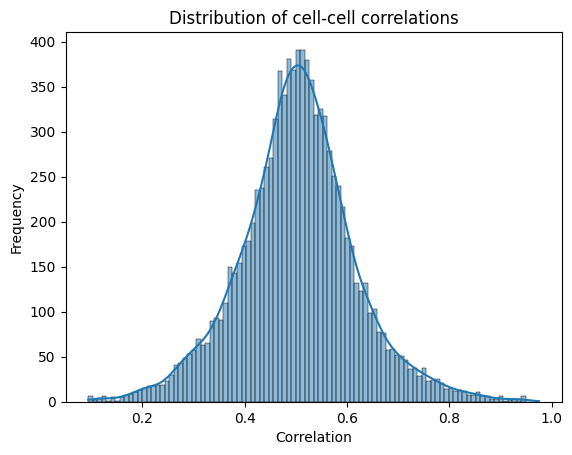

In [20]:
#sample 100 random pairs of cells and calculate the correlation and pvalue between them:
correlations = []
pvalues = []

for i in range(10000):
    cell1 = np.random.choice(data.index)
    cell2 = np.random.choice(data.index)
    if cell1 == cell2:
        continue
    corr, pval = pearsonr(data.loc[cell1], data.loc[cell2])
    correlations.append(corr)
    pvalues.append(pval)

sns.histplot(correlations, bins=100, kde=True)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Distribution of cell-cell correlations")
plt.show()

Discuss the statistical significance of the test for correlation between two cells, including the multiple-testing effect:

* In order to get the correlation between two cells a high dimenstional vector representing each cell and given as an input to compute the correlation matrix.
  The correaltion you get in return is a general correlation over all genes and might lose information of some specific genes that are highly correlated between the cells but are shadowed by the entire expression of the cell.
  Comparing such large number of samples between each other results in many statistical tests and a large flase discovery rate. Thus, a correction of the false discovery rate is needed in order to reduce the number false positives in our statistical analysis.      

9.  Consider the pair of cells "190307_P10.190307_P10350" and "190313_P12.190313_P12102", are they more similar than average?

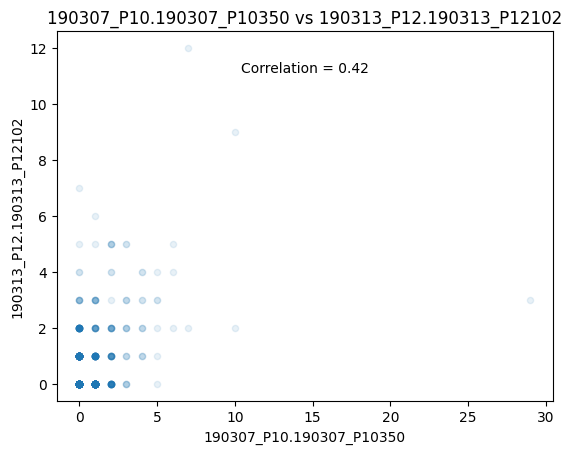

In [21]:
cell1 = '190307_P10.190307_P10350'
cell2 = '190313_P12.190313_P12102'

#get the correlation between the two cells:
corr, pval = pearsonr(data.loc[cell1], data.loc[cell2])

plt.scatter(data.loc[cell1], data.loc[cell2], s=20, alpha=0.1)
plt.xlabel(cell1)
plt.ylabel(cell2)
plt.title(f"{cell1} vs {cell2}")
plt.text(0.5, 0.9, f"Correlation = {corr:.2f}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()


This cells are slightly under correlated than the average

9.	What are the most correlated genes? Cells?

In [22]:
print(f'The two most correlated genes are {gene1} and {gene2} with a correlation of {corrmat[x, y]:.5f}')

The two most correlated genes are Col4a1 and Col4a2 with a correlation of 0.91124


In [23]:
corrmat = np.corrcoef(data)
np.fill_diagonal(corrmat, 0)
max_id = np.argmax(corrmat)
max_idx_2d = np.unravel_index(max_id, corrmat.shape)
x, y = max_idx_2d

cell1, cell2 = data.index[x], data.index[y] 

print(f'The two most correlated cells are {cell1} and {cell2} with a correlation of {corrmat[x, y]:.5f}')

The two most correlated cells are 190527_P102.190527_P102241 and 190527_P104.190527_P104150 with a correlation of 0.98964


10.  Compute FDR (False Discovery Rate) to estimate how much of the signal is significant. Repeat the same computations with the matrix after replacing each value x by log(1+x) and normalizing columns such that their sums are 0. Discuss the reasons for the differences between the outcomes. 

In [ ]:
def corrcoef(matrix):
    r = np.corrcoef(matrix)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2  # Degrees of freedom
    ts = rf * rf * (df / (1 - rf * rf))  # T-statistic
    pf = betainc(0.5 * df, 0.5, df / (df + ts))  # P-values using betainc
    
    p = np.zeros(shape=r.shape)  # Initialize p-value matrix
    p[np.triu_indices(p.shape[0], 1)] = pf  # Fill upper triangular part
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]  # Symmetric fill
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])  # Diagonal is 1 (self-correlation)
    
    return r, p

# def calculate_fdr(p_values):
#     p_values_flattened = p_values.flatten()
#     sorted_p_values = np.sort(p_values_flattened)
#     n = len(sorted_p_values)  
#     new_p_values = np.empty(n)
#     for i, p_value in enumerate(sorted_p_values):
#         new_p_values[i] = p_value * n / (i + 1)
#     new_p_values_reshaped = new_p_values.reshape(p_values.shape)

#     return new_p_values_reshaped

def built_in_fdr(p_values):
    p_values_flattened = p_values.flatten()
    reject, pvals_corrected, _, _ = multipletests(p_values_flattened, method='fdr_bh')
    pvals_corrected_reshaped = pvals_corrected.reshape(p_values.shape)
    
    return pvals_corrected_reshaped



In [ ]:
r_vals, p_vals = corrcoef(data)
# fdr_mar = calculate_fdr(p_vals)
fdr_mar_built_in = built_in_fdr(p_vals)

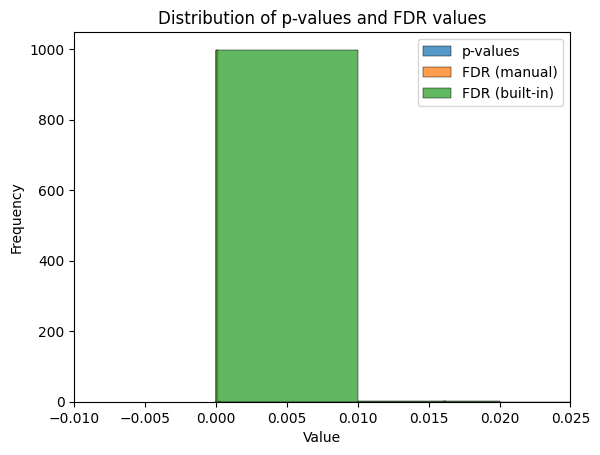

In [ ]:
#sample 1000000 random values from p_vals and plot their distribution:
sampled_p_vals = np.random.choice(p_vals.flatten(), 1000)
# sampled_fdr = np.random.choice(fdr_mar.flatten(), 1000)
sampled_fdr_built_in = np.random.choice(fdr_mar_built_in.flatten(), 1000)

sns.histplot(sampled_p_vals, bins=100)
sns.histplot(sampled_fdr, bins=100)
sns.histplot(sampled_fdr_built_in, bins=100)

plt.legend(["p-values", "FDR (manual)", "FDR (built-in)"])
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of p-values and FDR values")
plt.xlim(-0.01, 0.025)
plt.show()

In [ ]:
def transform_data(data):
    data_log = np.log1p(data)
    column_sums = data_log.sum(axis=0)
    data_normalized = data_log - column_sums / data_log.shape[0]
    
    return data_normalized

data_normalized = transform_data(data)

r_vals, p_vals = corrcoef(data_normalized)
fdr_mar = calculate_fdr(p_vals)
fdr_mar_built_in = built_in_fdr(p_vals)

sampled_p_vals = np.random.choice(p_vals.flatten(), 10000)
sampled_fdr = np.random.choice(fdr_mar.flatten(), 10000)
sampled_fdr_built_in = np.random.choice(fdr_mar_built_in.flatten(), 10000)

sns.histplot(p_vals.flatten(), bins=100, kde=True)
sns.histplot(fdr_mar.flatten(), bins=100, kde=True)
sns.histplot(fdr_mar_built_in.flatten(), bins=100, kde=True)

plt.legend(["p-values", "FDR (manual)", "FDR (built-in)"])
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of p-values and FDR values")
plt.show()


In [ ]:
#compure fdr on corrmat:


Extra: find a reasonable way to shuffle the matrix and compare the correlations on the real matrix to the shuffled one. What structures in the matrix should your reshuffling strategy conserve? Which should be eliminated?
Hint reading? : https://mathworld.wolfram.com/CorrelationCoefficient.html 
